In [6]:
#Import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import t

Matplotlib is building the font cache; this may take a moment.


In [7]:
def create_df_response(samples, time, date_init ='2020-03-06',
                       quantiles = [50, 80, 95], forecast_horizon=27,
                       dates=None, use_future=False):
    """[summary]

    Args:
        samples ([type]): [description]
        time ([type]): [description]
        date_init (str, optional): [description]. Defaults to '2020-03-06'.
        forecast_horizon (int, optional): [description]. Defaults to 27.
        use_future (bool, optional): [description]. Defaults to False.

    Returns:
        [type]: [description]
    """
    if dates is not None:
        dates_fitted = dates
    else:
        dates_fitted   = pd.date_range(start=pd.to_datetime(date_init),
                                       periods=time, freq='W')
        dates_forecast = pd.date_range(start=dates_fitted[-1]+timedelta(1),
                                       periods=forecast_horizon)

    dates = list(dates_fitted)
    types = ['estimate']*len(dates_fitted)
    if use_future:
        dates += list(dates_forecast)
        types  += ['forecast']*len(dates_forecast)

    results_df = pd.DataFrame(samples.T)
    df_response = pd.DataFrame(index=dates)

    df_response['mean']        = results_df.mean(axis=1).values
    df_response['median']      = results_df.median(axis=1).values
    df_response['std']         = results_df.std(axis=1).values

    for quant in quantiles:
        low_q  = ((100-quant)/2)/100
        high_q = 1-low_q

        df_response[f'low_{quant}']  = results_df.quantile(q=low_q,
                                                           axis=1).values
        df_response[f'high_{quant}'] = results_df.quantile(q=high_q,
                                                           axis=1).values

    df_response['type']        =  types
    df_response.index.name = 'date'
    return df_response

In [8]:
#Import data
dataset = pd.read_csv("../Data/finaldata3.csv", parse_dates=['Date'], index_col='Date')
print(dataset.shape)
dataset.head()

(781, 17)


,Dengue,Dengue_grave,Mortalidad_por_dengue,denguedolor de cabezamigrananauseasvomitobrotefiebrehemorragia,dolor ojospicadura mosquito,sintomas dengue,dolor muscular,mosquito,mosquito dengue,dengue hemorragico,mosquitos,dolor huesos,dolor articulaciones,mean_temperature,min_temperature,max_temperature,mean_rain
Date,,,,,,,,,,,,,,,,,
2007-01-07,663.0,116.0,0.0,16.482143,24.285714,27.142857,40.142857,5.285714,0.000000,0.000000,0.000000,8.571429,28.571429,28.857133,4.69,41.43,7.507262
2007-01-14,415.0,86.0,0.0,11.839286,19.857143,14.285714,0.000000,12.428571,4.857143,19.000000,0.000000,15.428571,10.142857,29.518629,-9.55,44.77,6.028485
2007-01-21,515.0,93.0,0.0,10.964286,0.000000,7.142857,19.428571,0.000000,0.000000,4.142857,19.000000,0.000000,3.000000,29.889693,-0.85,46.29,9.285873
2007-01-28,506.0,71.0,0.0,12.375000,16.714286,7.571429,5.142857,17.714286,9.285714,7.142857,0.000000,0.000000,3.857143,30.552598,5.57,45.77,5.877031
2007-02-04,613.0,120.0,1.0,9.678571,11.285714,0.000000,5.142857,9.000000,10.285714,4.000000,19.142857,12.000000,6.285714,31.604080,6.17,46.53,3.078355


In [9]:
# Scaling and normalizing data.
scaler      = MinMaxScaler()
data_scaled = scaler.fit_transform(dataset)
dataset1    = pd.DataFrame(data_scaled, index = dataset.index,
                        columns = dataset.columns)
dataset1.head()

,Dengue,Dengue_grave,Mortalidad_por_dengue,denguedolor de cabezamigrananauseasvomitobrotefiebrehemorragia,dolor ojospicadura mosquito,sintomas dengue,dolor muscular,mosquito,mosquito dengue,dengue hemorragico,mosquitos,dolor huesos,dolor articulaciones,mean_temperature,min_temperature,max_temperature,mean_rain
Date,,,,,,,,,,,,,,,,,
2007-01-07,0.077858,0.279518,0.000000,0.192308,0.371179,0.409483,0.528195,0.067766,0.000000,0.000000,0.000000,0.140187,0.434783,0.370634,0.958048,0.042232,0.069727
2007-01-14,0.019874,0.207229,0.000000,0.112943,0.303493,0.215517,0.000000,0.159341,0.096866,0.357527,0.000000,0.252336,0.154348,0.427041,0.633379,0.168175,0.051001
2007-01-21,0.043255,0.224096,0.000000,0.097985,0.000000,0.107759,0.255639,0.000000,0.000000,0.077957,0.243144,0.000000,0.045652,0.458682,0.831737,0.225490,0.092249
2007-01-28,0.041150,0.171084,0.000000,0.122100,0.255459,0.114224,0.067669,0.227106,0.185185,0.134409,0.000000,0.000000,0.058696,0.515209,0.978112,0.205882,0.049083
2007-02-04,0.066168,0.289157,0.071429,0.076007,0.172489,0.000000,0.067669,0.115385,0.205128,0.075269,0.244973,0.196262,0.095652,0.604871,0.991792,0.234540,0.013644


In [10]:
# Separate lagged data from current data and their respective targets

# Select data to be lagged.
selected_columns = ['Dengue', 'Dengue_grave', 'Mortalidad_por_dengue',
    #    'denguedolor de cabezamigrananauseasvomitobrotefiebrehemorragia',
    #    'dolor ojospicadura mosquito',
    #     'sintomas dengue', 'dolor muscular',
    #    'mosquito', 'mosquito dengue', 'dengue hemorragico', 'mosquitos',
    #    'dolor huesos', 'dolor articulaciones',
        'mean_temperature', 'min_temperature', 'max_temperature', 'mean_rain']
data = dataset1[selected_columns]

lag = 2

lagged_data = data.shift(lag)
lagged_data = lagged_data.iloc[:-lag].dropna()

# Select actual data.
selected_columns = [
    # 'denguedolor de cabezamigrananauseasvomitobrotefiebrehemorragia',
    # 'dolor ojospicadura mosquito',
    # 'sintomas dengue', 'dolor muscular',
    #    'mosquito', 'mosquito dengue', 'dengue hemorragico', 'mosquitos',
    #    'dolor huesos', 'dolor articulaciones',
    'mean_temperature', 'min_temperature', 'max_temperature', 'mean_rain']
actual_data = dataset1[selected_columns]
actual_data = actual_data.iloc[lag:-lag]
actual_data.head()

# Select the final target.
target = dataset1['Dengue']
target = target.iloc[lag:-lag]

# Join current and lagged data.
data = pd.concat([lagged_data.reset_index(),
                  actual_data.reset_index(drop=True)],
                 axis=1)
data = data.set_index('Date')

In [11]:
# Split data for training, validation and test.
train_data   = data.iloc[:8*52]
train_target = target.iloc[:8*52]

val_data   = data.iloc[8*52:9*52]
val_target = target.iloc[8*52:9*52]

test_data   = data.iloc[9*52:]
test_target = target.iloc[9*52:]

In [12]:
# Calculate the variance of the test data in each of the weeks of the year.
df      = test_data.reset_index()#test_decoder_data.reset_index()#
df_var  = df.groupby(df['Date'].dt.week).var().dropna()
df_mean = test_data#test_decoder_data#

# Create new data to test the model.
new_dfs = []

for _ in range(100):
    values = []
    for index, row in df_mean.iterrows():
        mean_values = row.values
        week_number = index.week
        # Ignore week 53 and use until week 52 of the year.
        if week_number != 53:
            var_values = df_var.loc[week_number].values
        else:
            var_values = df_var.loc[week_number-1].values

        # Sample the data from a normal distribution that takes the actual data
        # for that week as the mean and the square root of the variance
        # calculated for each week of the year as the standard deviation.
        values.append(np.random.normal(mean_values, np.sqrt(var_values)))

    # Create the final dataframe for the test.
    new_df = pd.DataFrame(np.array(values), columns = df_mean.columns,
                          index = df_mean.index)

    new_dfs.append(new_df)

C:\Users\Juan\AppData\Local\Temp\ipykernel_8652\2654162940.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_var  = df.groupby(df['Date'].dt.week).var().dropna()
C:\Users\Juan\AppData\Local\Temp\ipykernel_8652\2654162940.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_var  = df.groupby(df['Date'].dt.week).var().dropna()


In [13]:
# Define the time steps for the encoder and decoder input and output.
n_steps_in  = 8
n_steps_out = 1

# Create the input sequences function.
def create_sequences(encoder_data, decoder_data, target_data, n_steps_in,
                     n_steps_out):
    X_encoder, X_decoder, y = [], [], []

    for i in range(n_steps_in, len(encoder_data) - n_steps_out):
        encoder_seq = encoder_data[i - n_steps_in:i, :]
        decoder_seq = decoder_data[i:i + n_steps_out, :]
        target_seq  = target_data[i:i + n_steps_out]

        X_encoder.append(encoder_seq)
        X_decoder.append(decoder_seq)
        y.append(target_seq)

    return np.array(X_encoder), np.array(X_decoder), np.array(y)

# Create the train, validation and test sequences for the model.
X_train_encoder, X_train_decoder, train_y = create_sequences(train_data.values,
                                                             train_data.values,
                                                             train_target.values,
                                                             n_steps_in,
                                                             n_steps_out)
X_val_encoder, X_val_decoder, val_y = create_sequences(val_data.values,
                                                       val_data.values,
                                                       val_target.values,
                                                       n_steps_in, n_steps_out)
X_test_encoder, X_test_decoder, test_y = create_sequences(test_data.values,
                                                          test_data.values,
                                                          test_target.values,
                                                          n_steps_in,
                                                          n_steps_out)

print(X_train_encoder.shape, X_train_decoder.shape, train_y.shape,
      X_val_encoder.shape, X_val_decoder.shape, val_y.shape,
      X_test_encoder.shape, X_test_decoder.shape, test_y.shape)

(407, 8, 11) (407, 1, 11) (407, 1) (43, 8, 11) (43, 1, 11) (43, 1) (300, 8, 11) (300, 1, 11) (300, 1)


In [14]:
# Create the sequences for the multiples test.
tests_data = []

for d in new_dfs:
    X_test_encoder1, test_data1, test_y1 = create_sequences(test_data.values,
                                                            d.values,
                                                            test_target.values,
                                                            n_steps_in,
                                                            n_steps_out)
    tests_data.append(test_data1)

In [15]:
# Define the number of features
n_features_encoder = 11
n_features_decoder = 11

# Create the model
encoder_inputs                    = Input(shape=(n_steps_in,
                                                 n_features_encoder))
encoder_lstm                      = LSTM(100, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

decoder_inputs        = Input(shape=(n_steps_out, n_features_decoder))
decoder_lstm          = LSTM(100, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=[state_h, state_c])

output = Dense(1, activation = 'sigmoid')(decoder_outputs)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0001)

model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='mean_absolute_error', metrics=['mae'])
# Fit the mmodel
model.fit([X_train_encoder, X_train_decoder], train_y,
          validation_data=([X_val_encoder, X_val_decoder], val_y),
          epochs=100,
          batch_size=2,
          shuffle=True)#,
        #   callbacks=[reduce_lr])

Epoch 1/100
204/204 [==============================] - 5s 8ms/step - loss: 0.2081 - mae: 0.2081 - val_loss: 0.1748 - val_mae: 0.1748
Epoch 2/100
204/204 [==============================] - 1s 4ms/step - loss: 0.1152 - mae: 0.1152 - val_loss: 0.0683 - val_mae: 0.0683
Epoch 3/100
204/204 [==============================] - 1s 4ms/step - loss: 0.0630 - mae: 0.0630 - val_loss: 0.0888 - val_mae: 0.0888
Epoch 4/100
204/204 [==============================] - 1s 4ms/step - loss: 0.0610 - mae: 0.0610 - val_loss: 0.0730 - val_mae: 0.0730
Epoch 5/100
204/204 [==============================] - 1s 4ms/step - loss: 0.0579 - mae: 0.0579 - val_loss: 0.0785 - val_mae: 0.0785
Epoch 6/100
204/204 [==============================] - 1s 4ms/step - loss: 0.0550 - mae: 0.0550 - val_loss: 0.0783 - val_mae: 0.0783
Epoch 7/100
204/204 [==============================] - 1s 4ms/step - loss: 0.0547 - mae: 0.0547 - val_loss: 0.0727 - val_mae: 0.0727
Epoch 8/100
204/204 [==============================] - 1s 4ms/step - 

204/204 [==============================] - 1s 4ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0542 - val_mae: 0.0542
Epoch 63/100
204/204 [==============================] - 1s 4ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0564 - val_mae: 0.0564
Epoch 64/100
204/204 [==============================] - 1s 4ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0614 - val_mae: 0.0614
Epoch 65/100
204/204 [==============================] - 1s 4ms/step - loss: 0.0270 - mae: 0.0270 - val_loss: 0.0530 - val_mae: 0.0530
Epoch 66/100
204/204 [==============================] - 1s 4ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0570 - val_mae: 0.0570
Epoch 67/100
204/204 [==============================] - 1s 4ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0548 - val_mae: 0.0548
Epoch 68/100
204/204 [==============================] - 1s 4ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0561 - val_mae: 0.0561
Epoch 69/100
204/204 [==============================] - 1s 4ms/step - loss:

In [16]:
# Test the model
predictions = []
for t in tests_data:
    predictions.append(model.predict([X_test_encoder, t], verbose=0))
predictions.append(model.predict([X_test_encoder, X_test_decoder]))
RMSE = []
for i in predictions:
    RMSE.append(np.sqrt(mean_squared_error(i.reshape(-1), test_y.reshape(-1))))
rmse = np.median(np.array(RMSE))
print("RMSE:", rmse)

10/10 [==============================] - 0s 3ms/step
RMSE: 0.07536190434085521


In [17]:
RMSE[-1]

0.06773983589550092

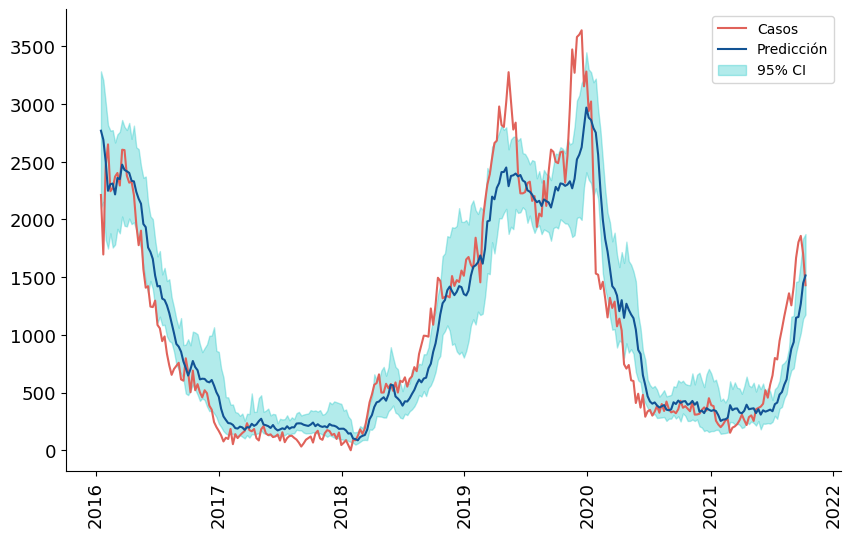

0.07536190434085521


In [28]:
results = create_df_response(np.array(predictions)[:,:,0,0], i.shape[0],
                             date_init = test_target.index[1])
# Plot results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(results.index.values, test_y[:, 0]*dataset['Dengue'].max(), 
        label='Casos', color = "#E0625A")
ax.plot(results.index.values, results['median']*dataset['Dengue'].max(),
        label='Predicción', color = "#125394")
ax.fill_between(results.index.values, results["high_95"]*dataset['Dengue'].max(),
                results["low_95"]*dataset['Dengue'].max(), color='c', alpha=0.3,
                label='95% CI')

ax.tick_params( which='both', axis='x', labelrotation=90, labelsize=13)
ax.tick_params( which='both', axis='y', labelsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(fontsize=20)

# plt.title(rmse)
plt.legend()
plt.show()
print(rmse)

In [ ]:
# Save the model
model.save_weights('model_weights605.h5')